Question 2:


Average accuracy from Cross-validation: 0.78


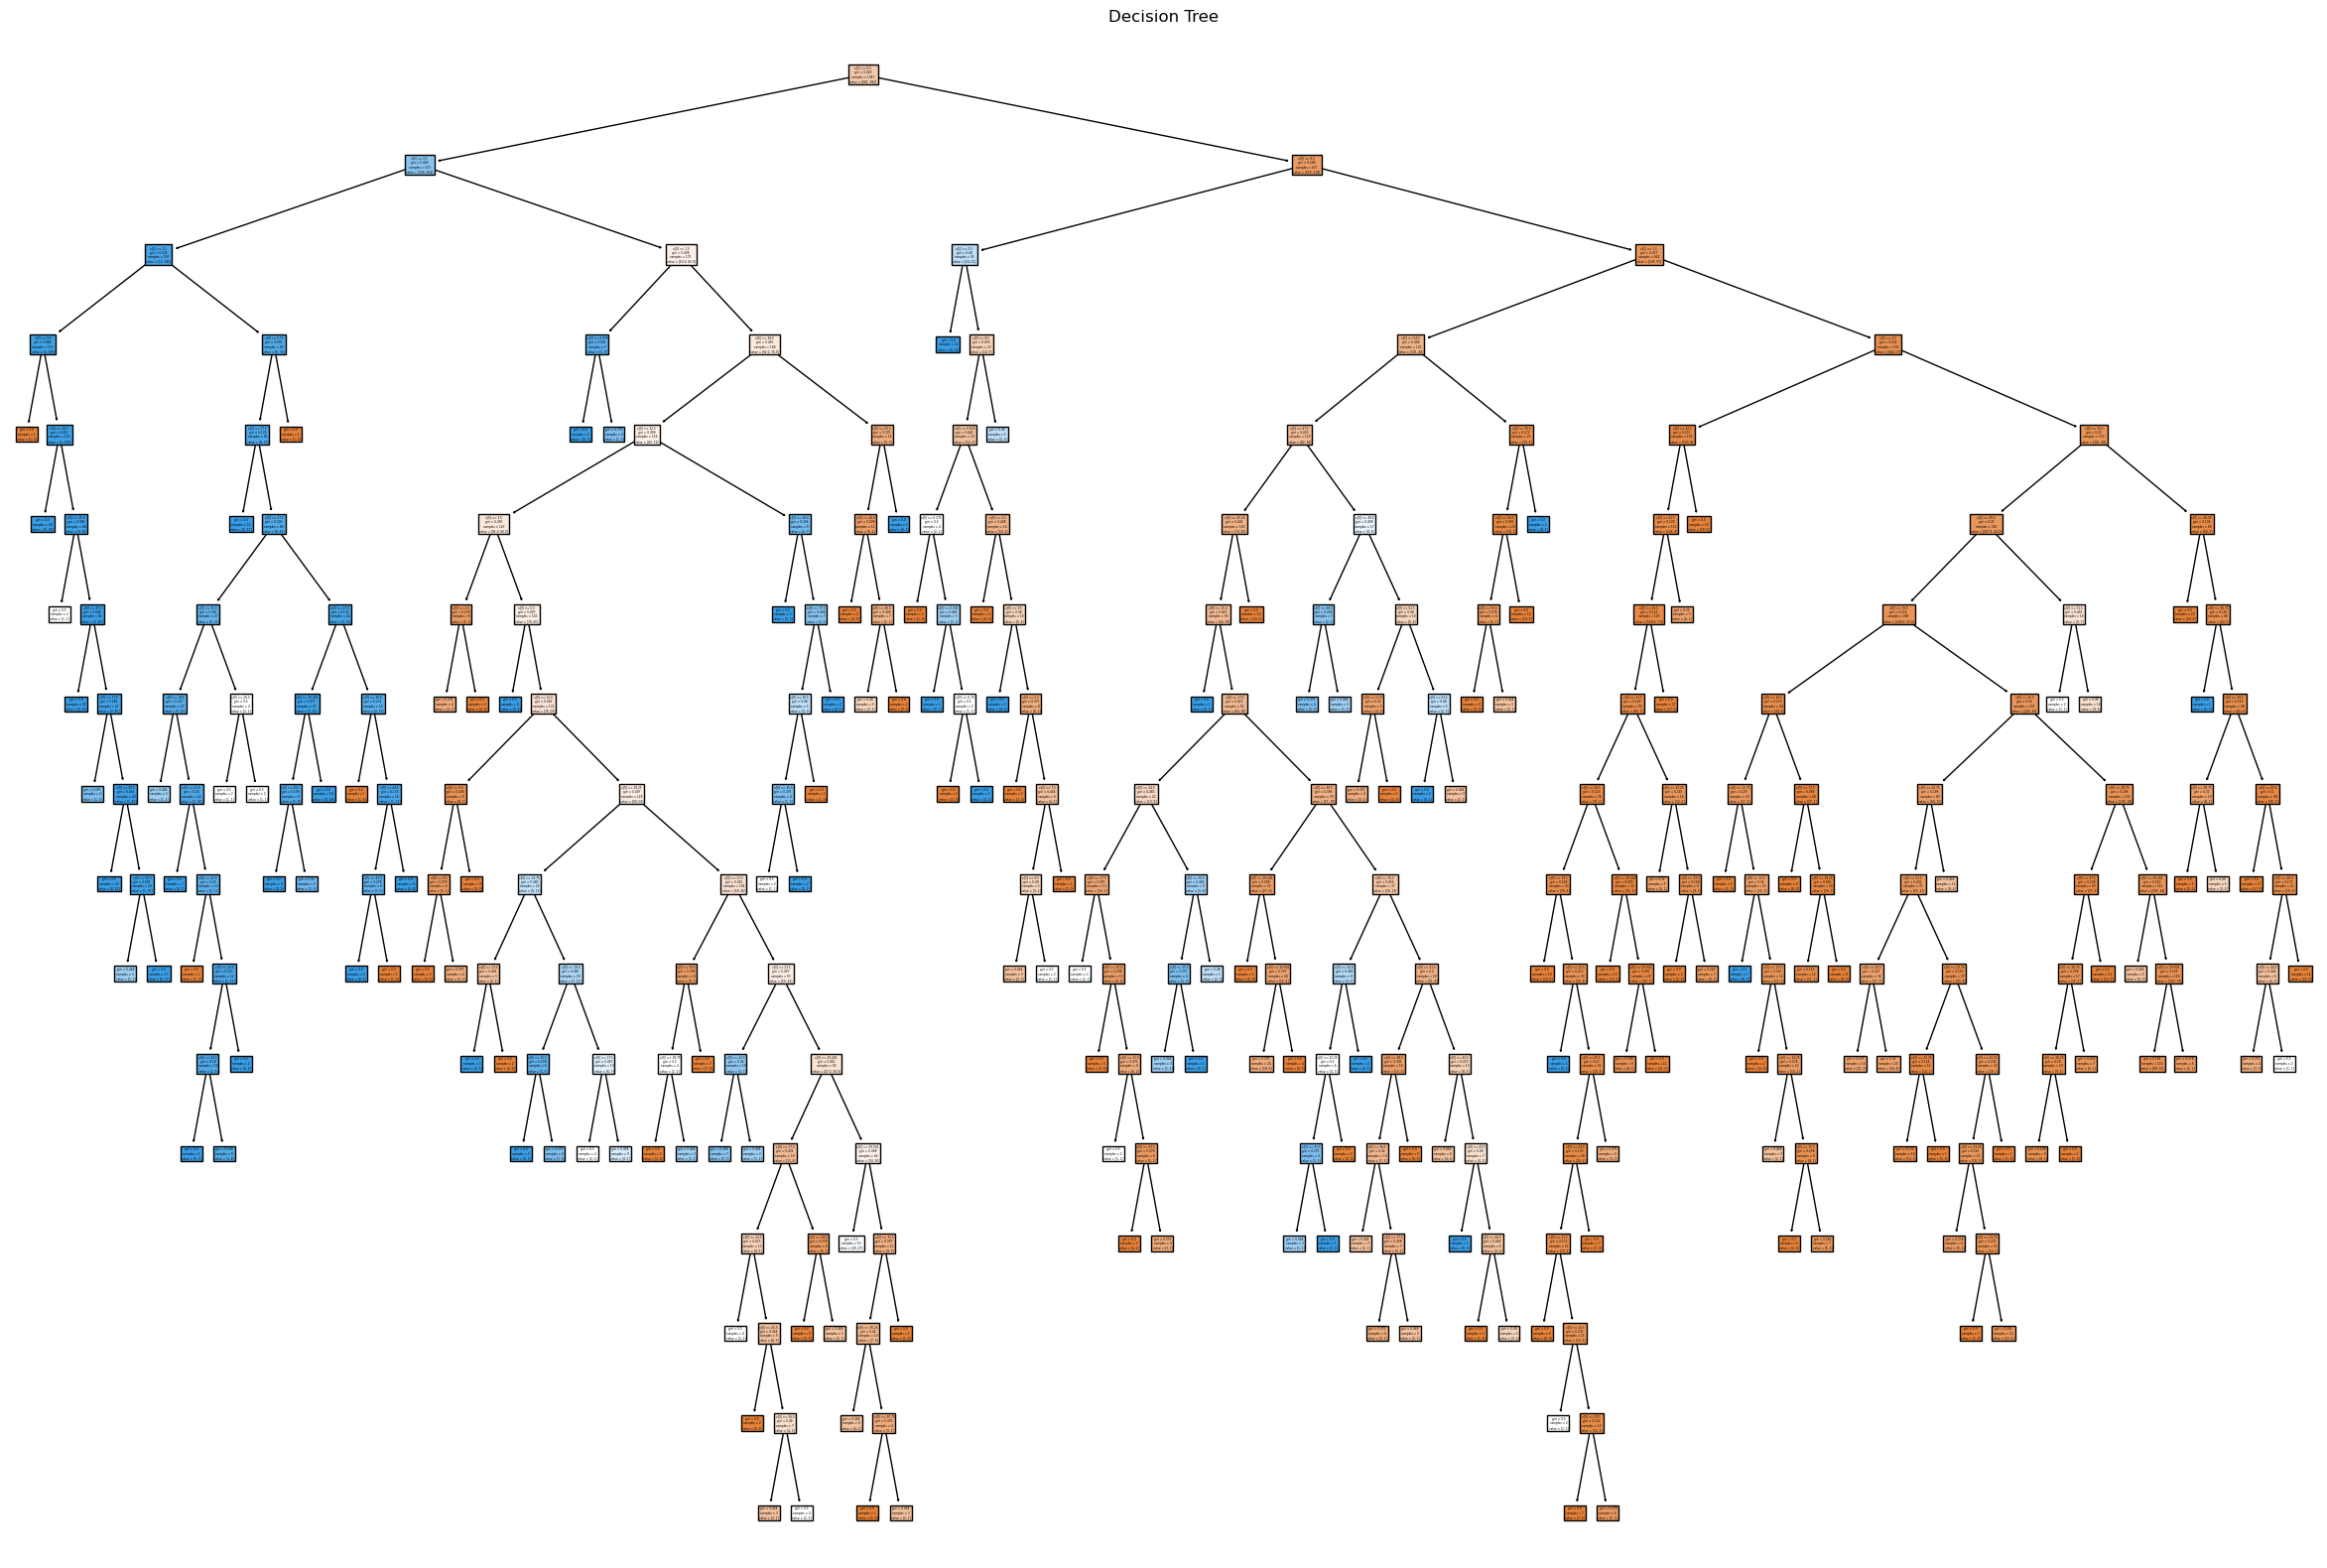

Before Pruning - Accuracy: 0.74
Before Pruning - Misclassification Error Rate:0.26
Before Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79       144
           1       0.80      0.57      0.66       118

    accuracy                           0.74       262
   macro avg       0.76      0.72      0.73       262
weighted avg       0.75      0.74      0.73       262

Before Pruning - Confusion Matrix:

[[127  17]
 [ 51  67]]


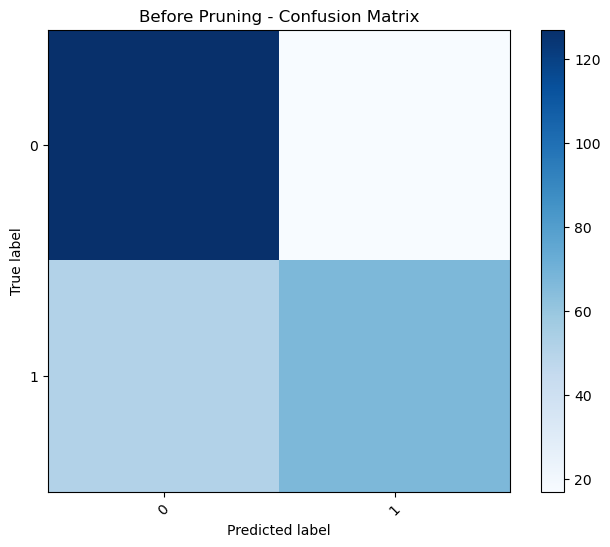

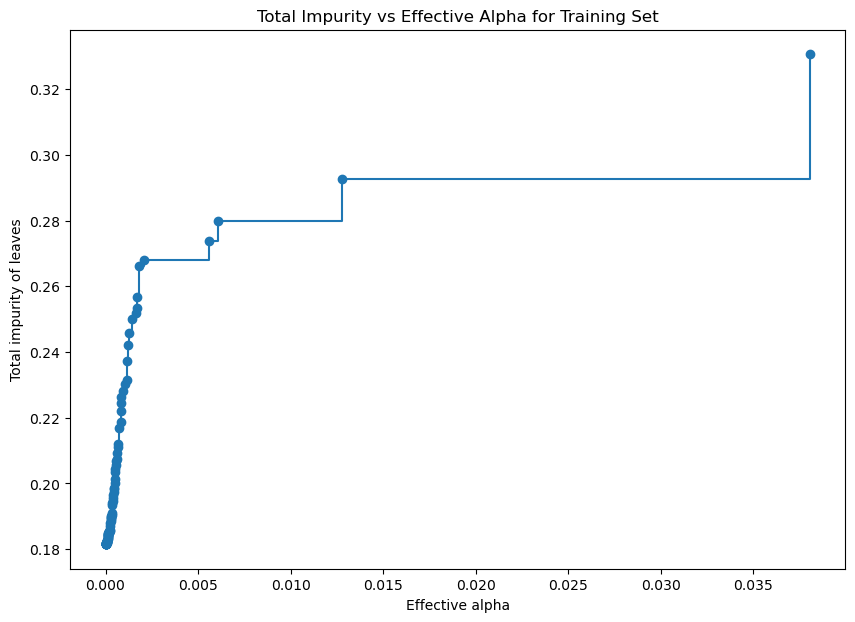

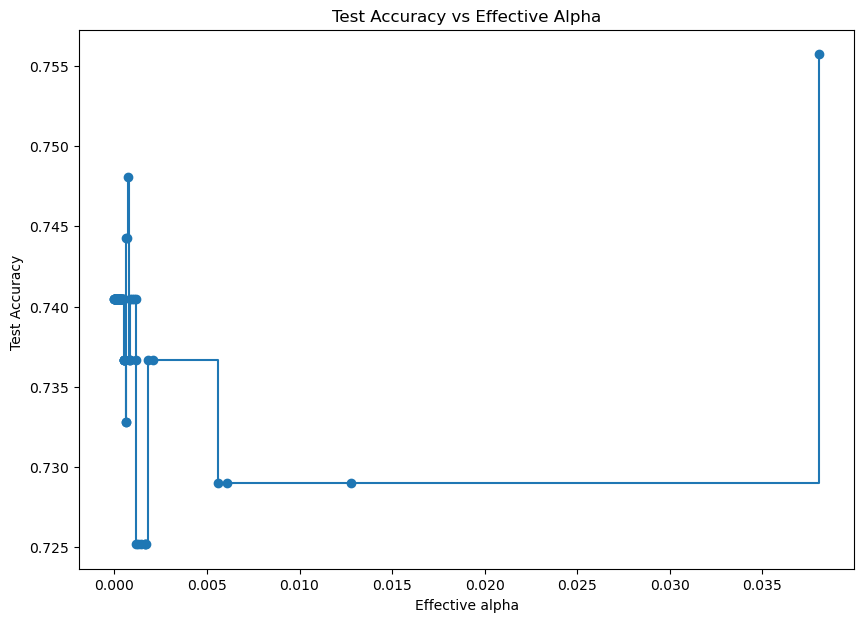

Best ccp_alpha: 0.03805531278310645, with accuracy: 0.76
After Pruning - Accuracy: 0.76
After Pruning - Misclassification Error Rate:0.24
After Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.78      0.64      0.70       118

    accuracy                           0.76       262
   macro avg       0.76      0.74      0.75       262
weighted avg       0.76      0.76      0.75       262

After Pruning - Confusion Matrix:

[[123  21]
 [ 43  75]]


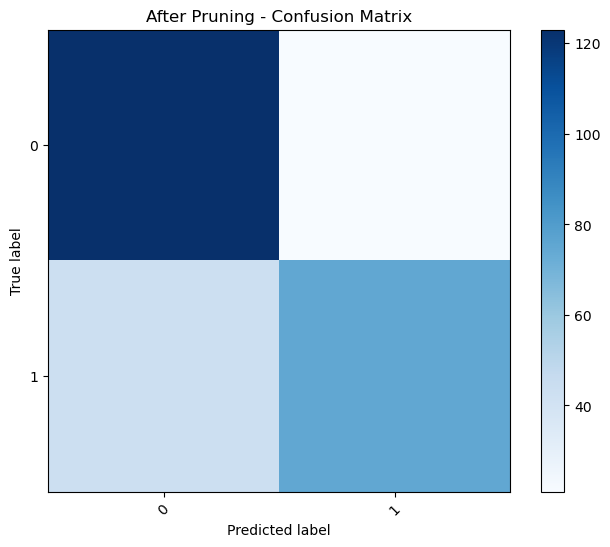

Logistic Regression - Accuracy: 0.77
Misclassification Error Rate: 0.23
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       144
           1       0.82      0.64      0.72       118

    accuracy                           0.77       262
   macro avg       0.79      0.76      0.77       262
weighted avg       0.78      0.77      0.77       262

Confusion Matrix:

[[128  16]
 [ 43  75]]


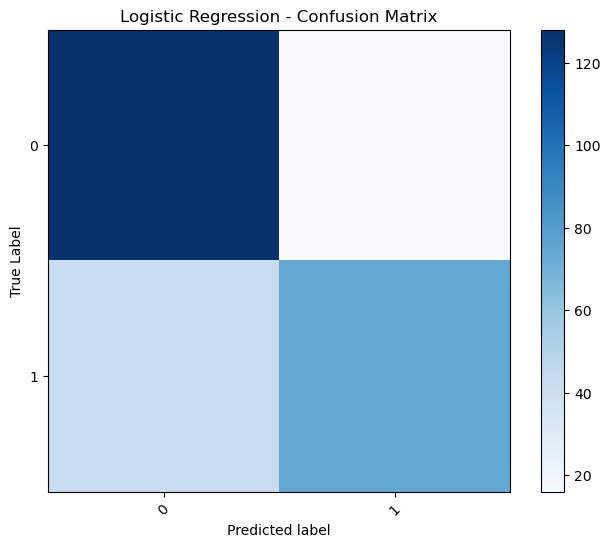

In [20]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
import numpy as np
# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree

# reading data from csv file
titan_df = pd.read_csv('data/titanic3.csv')
# print(titan_df) 

# drop unecesasary columns
titan_df = titan_df.drop(columns=['name','sibsp','parch','ticket','fare', 'cabin', 'embarked','boat','body','home.dest'])

# impute missing values using mean
mean_age = titan_df['age'].mean()
titan_df['age'] = titan_df['age'].fillna(mean_age)

# titan_df.describe()

# transform categorical features to numerical
titan_df['sex'] = titan_df['sex'].map({'female':0, 'male':1})

X = titan_df[['age', 'sex', 'pclass',]]

y=titan_df['survived'].astype(int)


# splitting data
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit decision tree classifier
model = DecisionTreeClassifier(random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train,cv=kfold)

print(f"Average accuracy from Cross-validation: {np.mean(cv_scores):.2f}")

model.fit(X_train, y_train)

# prediction on test data 
y_pred = model.predict(X_test)

# visualize the decision tree
plt.figure(figsize=(30,20))
plot_tree(model, filled=True)
plt.title("Decision Tree")
plt.show()

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate misclassification error
misclassification_error = 1-accuracy

print(f"Before Pruning - Accuracy: {accuracy:.2f}")
print(f"Before Pruning - Misclassification Error Rate:{misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("Before Pruning - Classification Report:\n", class_report)

# display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Before Pruning - Confusion Matrix:\n")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Before Pruning - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# visualize total impurity movement with different ccp_alpha
plt.figure(figsize=(10,7))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Total Impurity vs Effective Alpha for Training Set")
plt.show()

# train series of decision trees with diff values of ccp_alpha
models =[]
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train,y_train)
    models.append(model)
    
# find the accuracy for each pruned tree on test set
test_accuracies = [model.score(X_test, y_test) for model in models]

#plot accuracy vs alpha values
plt.figure(figsize=(10,7))
plt.plot(ccp_alphas[:-1], test_accuracies[:-1], marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Test Accuracy ")
plt.title("Test Accuracy vs Effective Alpha")
plt.show()

# find best alpha
best_alpha_index = np.argmax(test_accuracies)
best_alpha = ccp_alphas[best_alpha_index]
print(f"Best ccp_alpha: {best_alpha}, with accuracy: {test_accuracies[best_alpha_index]:.2f}")

# create pruned tree from best alpha
p_tree= DecisionTreeClassifier(ccp_alpha=best_alpha)
p_tree.fit(X_train, y_train)

# make predictions using best alpha pruned tree
y_pred = p_tree.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate misclassification error
misclassification_error = 1-accuracy

print(f"After Pruning - Accuracy: {accuracy:.2f}")
print(f"After Pruning - Misclassification Error Rate:{misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("After Pruning - Classification Report:\n", class_report)

# display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("After Pruning - Confusion Matrix:\n")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.title('After Pruning - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# now with the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# fit the model on training data
logistic_model.fit(X_train,y_train)

# make predictions on test
y_pred = logistic_model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calc misclassification error
misclassification_error = 1-accuracy

print(f"Logistic Regression - Accuracy: {accuracy:.2f}")
print(f"Misclassification Error Rate: {misclassification_error:.2f}")

# detailed report for further analysis
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n")
print(conf_matrix)

plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.show()









Question 3:


Accuracy: 0.77
Cross-validation Scores: [0.81679389 0.7480916  0.82442748 0.77862595 0.81679389 0.81679389
 0.84732824 0.82442748 0.70992366 0.75384615]
Mean Accuracy: 0.7937052260716383
Standard Deviation: 0.04156739637345006
Log Loss for each fold: [2.48555247972842, 1.7649135128800078, 1.9400157684495938, 2.5059573626892306, 1.696656322969799, 2.4715990559433525, 1.108890945072264, 1.9294333687463883, 2.0878072799186302, 2.0498247334977084]
Mean Log Loss: 2.0040650829895394
Resubstitution Log Loss: 0.41438601380547807
Optimal number of neighbors: 20


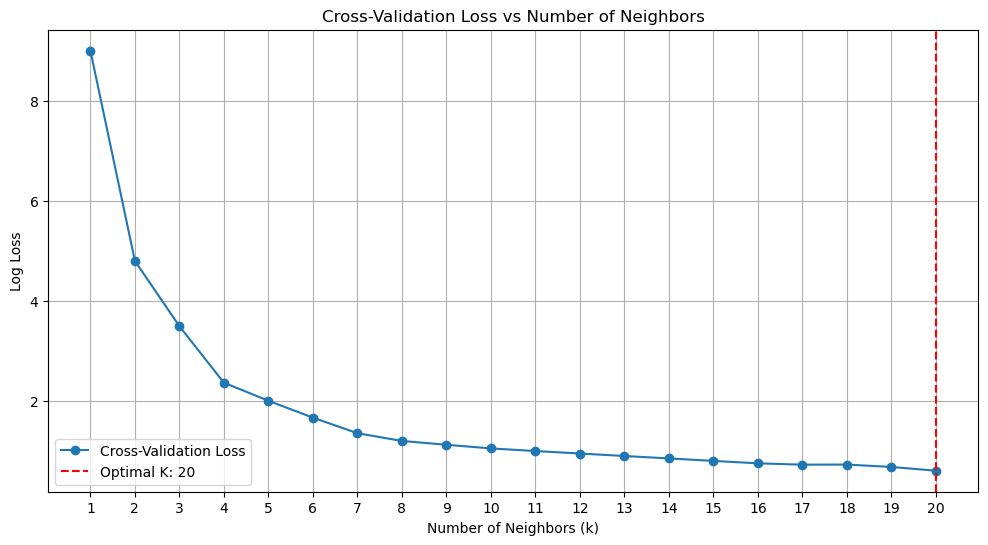

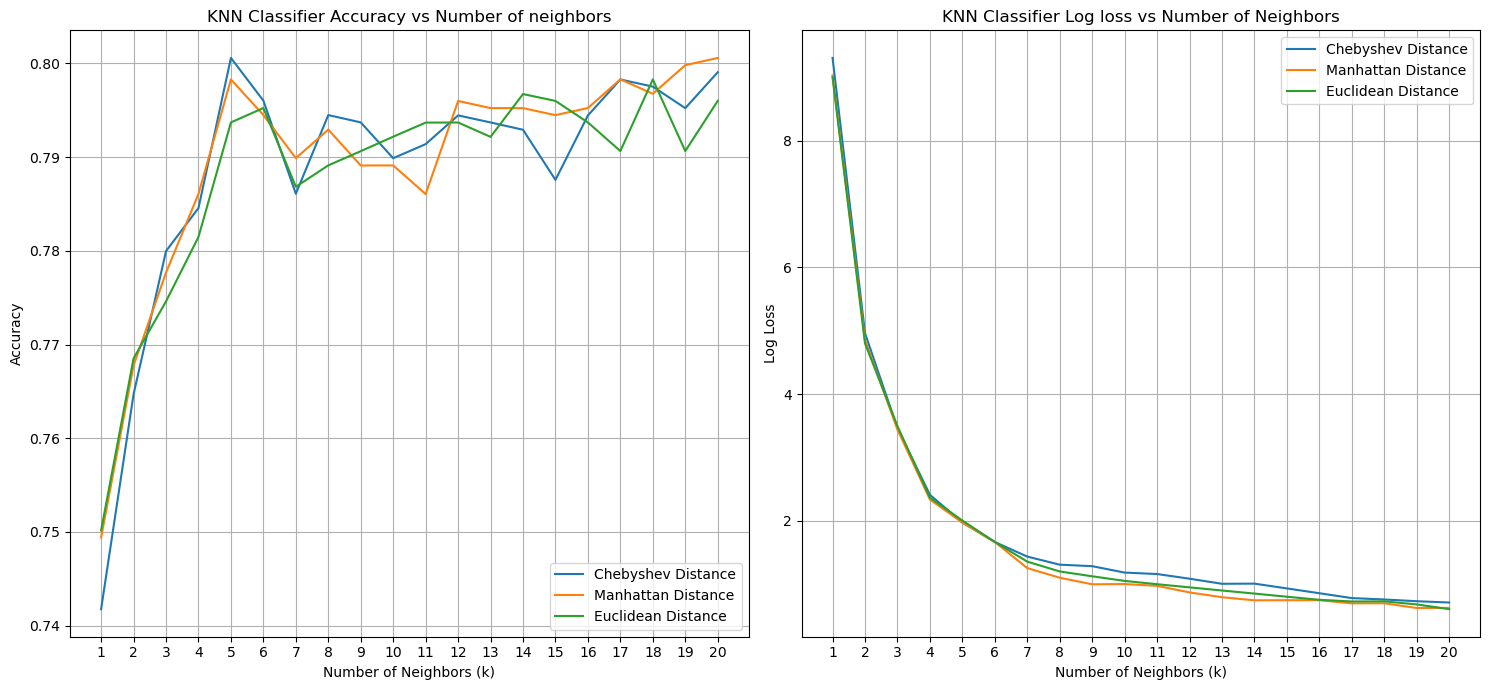


 Optimal k values for each distance metric:
{'chebyshev': 20, 'manhattan': 19, 'euclidean': 20}

 Best KNN Config: k=20, Distance Metric=euclidean
KNN Accuracy: 0.7404580152671756
KNN Log Loss: 0.6158875932410798
Logistic Regression Accuracy: 0.7709923664122137
Logistic Regression Log Loss: 0.4896831730240041

 Comparison of Models:
                 Model  Accuracy  Log Loss
0                  KNN  0.740458  0.615888
1  Logistic Regression  0.770992  0.489683


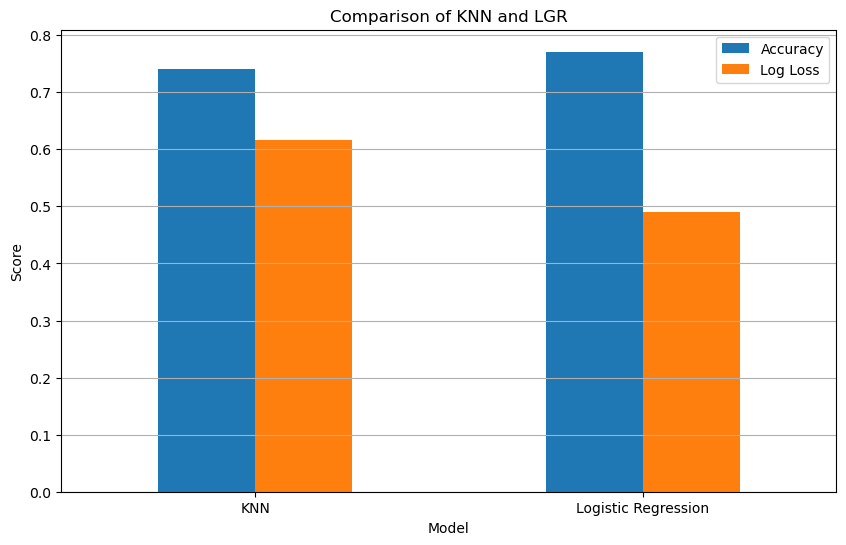

In [125]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
import numpy as np
# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

from sklearn.metrics import confusion_matrix, log_loss

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

# reading data from csv file
titan_df = pd.read_csv('data/titanic3.csv')
# print(titan_df) 

# drop unnecessary columns
titan_df = titan_df.drop(columns=['name','ticket', 'embarked','boat','body','cabin','home.dest'])

# impute missing values using mean
mean_age = titan_df['age'].mean()
titan_df['age'] = titan_df['age'].fillna(mean_age)

mean_fare = titan_df['fare'].mean()
titan_df['fare'] = titan_df['fare'].fillna(mean_fare)


# transform categorical features to numerical
titan_df['sex'] = titan_df['sex'].map({'female':0, 'male':1})

X = titan_df[['age', 'sex', 'pclass','sibsp', 'parch', 'fare']]

y=titan_df['survived'].astype(int)


# apply standard scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_scaled,y, test_size=0.2, random_state=42)


# create and fit decision tree classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# KFold cross validation setup
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

# # resubstitution loss
# y_pred_proba_in_sample = model.predict_proba(X_train)
# resubstitution_loss = log_loss(y_train, y_pred_proba_in_sample)

accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Default model evaluation using cross-validation 
cv_scores = cross_val_score(model, x_scaled, y, cv=kFold, scoring='accuracy')

print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")
# print(f"Resubstitution Log Loss: {resubstitution_loss:.4f}")

# finding the log loss for each fold (kfold loss)
logLosses = []

for train_index, test_index in kFold.split(x_scaled):
    X_train_f, x_test_f = x_scaled[train_index], x_scaled[test_index]
    y_train_f, y_test_f = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train_f, y_train_f)
    # loss = 1- model.score(X_test_f, y_test_f)
    y_pred_proba = model.predict_proba(x_test_f)
    logLosses.append(log_loss(y_test_f, y_pred_proba))
    

print(f'Log Loss for each fold: {logLosses}')
print(f'Mean Log Loss: {sum(logLosses)/len(logLosses)}')

# fit model on whole dataset to find resubstitution loss
model.fit(x_scaled, y)
y_train_pred_proba=model.predict_proba(x_scaled)

# calculate resubstitution log loss
resubstitution_loss = log_loss(y, y_train_pred_proba)

print(f'Resubstitution Log Loss: {resubstitution_loss}')



# setup grid for n_neighbours and test for neighbours upto 20 from 1
n_neighbors = range(1,21)
mean_accuracies = []
train_scores = []
cv_losses = []
in_sample_losses = []

# quick KFlod Cross -validation
for n in n_neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    f_losses = []

    for train_index, test_index in kFold.split(x_scaled): 
        X_train_fold, X_test_fold = x_scaled[train_index], x_scaled[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)
        
        # log loss for current fold
        f_losses.append(log_loss(y_test_fold, y_pred_proba_fold))
    
    # average log loss across fold for cross-validation loss
    cv_losses.append(np.mean(f_losses))
    
    model.fit(x_scaled, y)
    y_pred_proba_in_sample = model.predict_proba(x_scaled)
    in_sample_loss = log_loss(y, y_pred_proba_in_sample)
    in_sample_losses.append(in_sample_loss)


# optimal value of k
optimal_k = n_neighbors[cv_losses.index(min(cv_losses))]
print(f"Optimal number of neighbors: {optimal_k}")
    
plt.figure(figsize=(12,6))
plt.plot(n_neighbors, cv_losses, label='Cross-Validation Loss', marker='o')
plt.title('Cross-Validation Loss vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Log Loss')
plt.xticks(n_neighbors)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
plt.legend()
plt.grid()
plt.show()


def evaluate_k_model(distance_metric):
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    log_losses = []
    
    # run through different vals of n_neighbors
    for n_neighbor in n_neighbors:
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbor, metric=distance_metric)
        fold_accuracies = []
        fold_losses = []
        fold_in_sample_losses = []
        
        for train_index, test_index in kFold.split(x_scaled):
            X_train_fold, X_test_fold = x_scaled[train_index], x_scaled[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
            
            knn_model.fit(X_train_fold, y_train_fold)
            y_pred_proba_fold = knn_model.predict_proba(X_test_fold)
            
            fold_accuracies.append(accuracy_score(y_test_fold, knn_model.predict(X_test_fold)))
            fold_losses.append(log_loss(y_test_fold, y_pred_proba_fold))
            
        # average accuracy and log loss 
        accuracies.append(np.mean(fold_accuracies))
        log_losses.append(np.mean(fold_losses))
        
        # fitting the entire training set to get in-sample loss
        knn_model.fit(x_scaled, y)
        y_pred_proba_in_smaple = knn_model.predict_proba(x_scaled)
        fold_in_sample_losses.append(log_loss(y, y_pred_proba_in_smaple))
        
    return accuracies, log_losses, fold_in_sample_losses

# evaluate model distance metrics
# metrics = ['chebyshev', 'manhattan', 'euclidean', 'infinity', 'correlation', 'jaccard', 'hamming', 'sokalsneath', 'p', 'sqeuclidean', 'l1', 'canberra', 'nan_euclidean', 'dice', 'rogerstanimoto', 'cosine']
metrics = ['chebyshev', 'manhattan', 'euclidean']
results = {}

for metric in metrics:
    accuracies, log_losses, in_sample_losses = evaluate_k_model(metric)
    results[metric] = {
        'accuracies': accuracies,
        'log_losses': log_losses,
        'in_sample_losses': in_sample_losses
    }

plt.figure(figsize=(15,7))

# accuracies for each distance metric
plt.subplot(1,2,1)
for metric in metrics:
    plt.plot(n_neighbors, results[metric]['accuracies'], label=f'{metric.capitalize()} Distance')
plt.title('KNN Classifier Accuracy vs Number of neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(range(1,21))
plt.legend()
plt.grid()

# log losses for each distance metric
plt.subplot(1,2,2)
for metric in metrics:
    plt.plot(range(1,21), results[metric]['log_losses'], label=f'{metric.capitalize()} Distance')
plt.title('KNN Classifier Log loss vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Log Loss')
plt.xticks(range(1,21))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# optimal k for each metric
optimal_k_per_metric = {metric: n_neighbors[np.argmin(result['log_losses'])] for metric, result in results.items()}
print("\n Optimal k values for each distance metric:")
print(optimal_k_per_metric)

# find best overall k on  lowest cross validation log loss
best_metric = min(results.items(), key=lambda x: min(x[1]['log_losses']))[0]
optimal_k = optimal_k_per_metric[best_metric]
print(f"\n Best KNN Config: k={optimal_k}, Distance Metric={best_metric}")

# fit the knn model with optimal and best distance metric
final_k_model = KNeighborsClassifier(n_neighbors=optimal_k,metric=best_metric)

final_k_model.fit(X_train, y_train)
y_pred_knn = final_k_model.predict(X_test)
y_pred_proba_knn = final_k_model.predict_proba(X_test)

k_model_accuracy = accuracy_score(y_test,y_pred_knn)
k_log_loss = log_loss(y_test,y_pred_proba_knn)

print(f'KNN Accuracy: {k_model_accuracy}')
print(f'KNN Log Loss: {k_log_loss}')

# logistic regression
lgr_model = LogisticRegression()
lgr_model.fit(X_train, y_train)
y_pred_log_lgr = lgr_model.predict(X_test)
y_pred_proba_log_reg = lgr_model.predict_proba(X_test)
lgr_model_accuracy = accuracy_score(y_test, y_pred_log_lgr)
lgr_reg_log_loss = log_loss(y_test, y_pred_proba_log_reg)

print(f'Logistic Regression Accuracy: {lgr_model_accuracy}')
print(f'Logistic Regression Log Loss: {lgr_reg_log_loss}')

# comparison
results_df = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression'],
    'Accuracy': [k_model_accuracy, lgr_model_accuracy],
    'Log Loss': [k_log_loss, lgr_reg_log_loss]
})                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
print("\n Comparison of Models:")
print(results_df)

results_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('Comparison of KNN and LGR')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()




Old Reference:


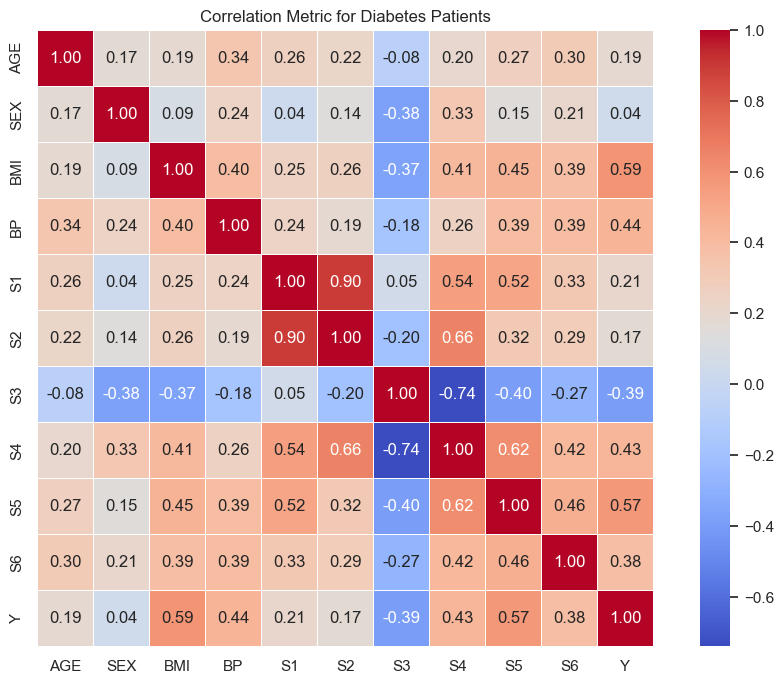

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           5.41e-50
Time:                        23:42:50   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -341.3782     74.073     -4.609      0.0

In [ ]:
# to use read_excel function
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
# to utilize correlation function
import numpy as np
# to utilize the fit (model) function
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import statsmodels.api as st



coefficients = model.coef_[0]
intercept = model.intercept_[0]

# odds ratio
odds_ratios = np.exp(coefficients)


X_with_intercept = st.add_constant(X_train)                 # adding intercept for statsmodels
np.asarray(X_with_intercept)
logit_model = st.Logit(y_train, X_with_intercept)
result = logit_model.fit()
print(result.summary())


# summary_table = pd.DataFrame({
#     'Coefficent': [intercept] + list(X.columns),
#     'Predictor': ['Intercept'] + list(coefficients),
#     'Odds_Ratio': [np.exp(intercept)] + list(odds_ratios),
#     'P_Value':[logit_model.pvalues[0]] + list(logit_model.pvalues[1:]) 
# })

# summary_table.reset_index(inplace=True)
# summary_table.rename(columns={'index':'Predictor'}, inplace=True)

# probabilities predictions on test set
predictions = model.predict_proba(X_test)[:,1]

# predicting class labels based on a threshold (default is 0.5)
y_pred = (predictions >= 0.5).astype(int)

# calculating evaluation matrix
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, predictions)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Scores below are on test set:")
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC Score: {auc_score:.2f}')
print(f'precision_score: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall Score: {recall:.2f}')

report = classification_report(y_test, np.where(predictions > 0.5, 1, 0))
print(report)

# print(model.summary())


def get_adjusted_r2_score(r2_score, n_observations, i_variables):
    return 1-((1-r2_score) * (n_observations-1)/(n_observations-i_variables-1))

def forwardSelection(X, y):    
    initialFeat = X.columns.tolist()
    selectedFeat = []
    
    while initialFeat:
        tempfeat = selectedFeat.copy()
        pvals = []
        
        for feature in initialFeat:
            model = st.OLS(y, st.add_constant(X[tempfeat +[feature]])).fit()
            pvals.append((model.pvalues[feature],feature))
            
        pvals.sort()
        if pvals[0][0] < 0.05:
            selectedFeat.append(pvals[0][1])
            initialFeat.remove(pvals[0][1])
        else:
            break
        
    return selectedFeat

# storing data from data source into respective data frames (both metadata and original data) 
diabetes_df = pd.read_excel('data/Diabetes_Data.xlsx')

corr = diabetes_df.corr()

sns.set(style='white')
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidth=.5)

plt.title('Correlation Metric for Diabetes Patients')
plt.show()

X= diabetes_df[['BMI', 'SEX', 'AGE','BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']]
y=diabetes_df['Y']


X_train, X_test, y_train, y_test = train_test_split(st.add_constant(X),y, test_size=0.2, random_state=42)

model = st.OLS(y_train, X_train).fit()

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions) 
print(model.summary())


print("R2: ", model.rsquared)
print("Adjusted R2: ", model.rsquared_adj)
print("Mean Squared Error: ", mse)
# print("R-Squared: ", r2)
# print("Adj-R-Squared: ", get_adjusted_r2_score(r2, len(y_test), X_test.shape[1]))


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.head())
X= diabetes_df.drop('Y', axis=1)
y = diabetes_df['Y']

# run forward selection
selectVariables = forwardSelection(X_train,y_train)
print("Selected Variables:", selectVariables)
X_train= st.add_constant(X_train[selectVariables])
# fit final model with selected variables
finalModel = st.OLS(y_train, X_train).fit()

mse = finalModel.mse_model
r_squared = finalModel.rsquared

print(finalModel.summary())

X_test= st.add_constant(X_test[selectVariables])
predictions = finalModel.predict(X_test)

# r2 = r2_score(y_test, predictions)

print(f"New model Statistics: \n")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, predictions)}")
# print(f"R-squared: {r2}")
print("Adj-R-Squared: ", get_adjusted_r2_score(r_squared, len(y_test), X_test.shape[1]))
# print("Adj-R-Squared: ", get_adjusted_r2_score(r2, len(y_test), X_test.shape[1]))

